In [1]:
#Continuous Severity Model

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
from pathlib import Path
BASE_DIR = Path().resolve()

DATA_PATH = BASE_DIR / "storms_data.csv"
df = pd.read_csv(DATA_PATH)

In [2]:
df["event_time"] = pd.to_datetime(df["BEGIN_DATE_TIME"], errors="coerce")
df = df[df["event_time"].notna()].copy()
df["month"] = df["event_time"].dt.month
required_target_cols = ["max_outage_after_24h", "housing_units"]
mask_valid = df["max_outage_after_24h"].notna() & df["housing_units"].notna() & (df["housing_units"] > 0)
df = df[mask_valid].copy()
df["outage_ratio"] = (df["max_outage_after_24h"] / df["housing_units"]).clip(0.0, 1.0)


# FEATURE LIST
feature_cols = [
    "era_i10fg_max_total_48h",
    "era_tp_max_total_48h",
    "era_crr_max_total_48h",
    'housing_units_by_area',
    "overhead_circuits",
    "n_points",
    "n_urban",
    "season_code",
    "cbp_emp_total",
]

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
df[feature_cols] = df[feature_cols].fillna(0)

X = df[feature_cols].copy()
y = df["outage_ratio"].copy()
y_t = np.log1p(100.0 * y)


# TRAIN/TEST SPLIT 
X_train, X_test, y_train_t, y_test_t = train_test_split(
    X, y_t,
    test_size=0.25,
    random_state=42,
)

# Keep original-scale y for reporting
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

# MODEL (XGBRegressor)
reg_model = XGBRegressor(
    n_estimators=900,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

reg_model.fit(X_train, y_train_t)

# EVALUATION (report in original outage_ratio scale)
y_pred_t = reg_model.predict(X_test)

# invert transform: outage_ratio_hat = (exp(y_t)-1)/100
y_pred = (np.expm1(y_pred_t) / 100.0).clip(0.0, 1.0)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n===== Continuous Severity (outage_ratio) Regression =====")
print(f"Test RMSE = {rmse:.6f}")
print(f"Test MAE  = {mae:.6f}")
print(f"Test R^2  = {r2:.4f}")


===== Continuous Severity (outage_ratio) Regression =====
Test RMSE = 0.028307
Test MAE  = 0.003189
Test R^2  = 0.8161


In [3]:
#PREDICT ALL rows (for plotting)
X_all = df[feature_cols].copy()
y_all_t_pred = reg_model.predict(X_all)
df["pred_outage_ratio"] = (np.expm1(y_all_t_pred) / 100.0).clip(0.0, 1.0)
df["pred_outage_pct"] = 100.0 * df["pred_outage_ratio"]

# observed percentage
df["obs_outage_pct"] = 100.0 * df["outage_ratio"]

In [4]:
# Build fips_str + aggregate to storm–county
if "full_fips" in df.columns:
    base_fips_col = "full_fips"
else:
    base_fips_col = next((c for c in ["CZ_FIPS", "cz_fips", "FIPS", "county_fips"] if c in df.columns), None)
    if base_fips_col is None:
        raise KeyError("Cannot find a county id column (full_fips/CZ_FIPS/FIPS/...).")

def to_fips_str(x):
    try:
        return f"{int(float(x)):05d}"
    except Exception:
        return np.nan

df["fips_str"] = df[base_fips_col].apply(to_fips_str)
df = df.dropna(subset=["fips_str"]).copy()

# time col already exists: df["event_time"]
group_cols = ["EVENT_ID", "fips_str"]

sev_stormcounty = (
    df.groupby(group_cols, as_index=False)
      .agg(
          event_time=("event_time", "min"),
          obs_pct=("obs_outage_pct", "max"),     
          pred_pct=("pred_outage_pct", "max"),
          n=("obs_outage_pct", "size")
      )
)
sev_stormcounty["month"] = sev_stormcounty["event_time"].dt.to_period("M").dt.to_timestamp()


In [5]:
def plot_monthly_history_vs_pred_outagepct_bar(sev_sc, target_fips, title_suffix=""):
    d = sev_sc[sev_sc["fips_str"] == str(target_fips)].copy()
    if d.empty:
        print(f"[Warn] No data for fips={target_fips}")
        return

    m = (d.groupby("month", as_index=False)
           .agg(
               obs_mean=("obs_pct", "mean"),
               pred_mean=("pred_pct", "mean"),
               n=("obs_pct", "size")
           )
           .sort_values("month"))

    x = np.arange(len(m))
    w = 0.4

    plt.figure(figsize=(14, 4))
    plt.bar(x - w/2, m["obs_mean"], width=w, label="Observed")
    plt.bar(x + w/2, m["pred_mean"], width=w, label="Predicted")

    plt.xticks(x, m["month"].dt.strftime("%Y-%m"), rotation=45)
    plt.xlabel("Month")
    plt.ylabel("Outage (%)")
    plt.title(f"Outage Magnitude (Severity): Observed vs Predicted (Monthly Mean)\nFIPS={target_fips} {title_suffix}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

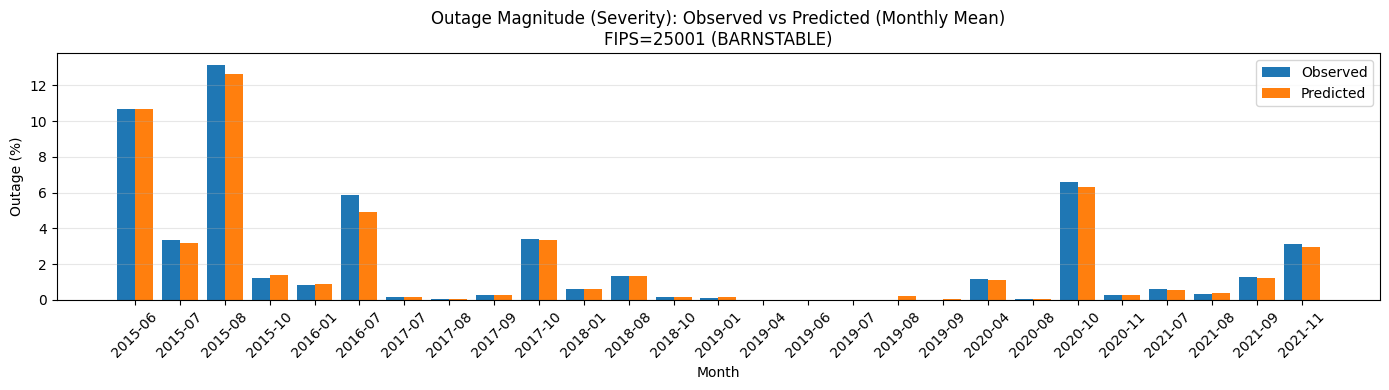

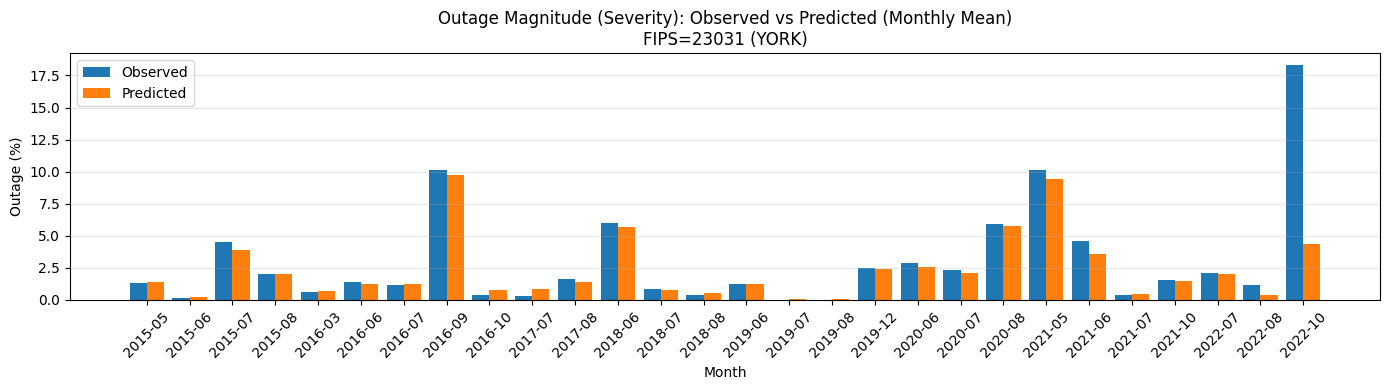

In [6]:
plot_monthly_history_vs_pred_outagepct_bar(sev_stormcounty, "25001", "(BARNSTABLE)")
plot_monthly_history_vs_pred_outagepct_bar(sev_stormcounty, "23031", "(YORK)")